Given a graph find the max cut of two different colored nodes in the graph.

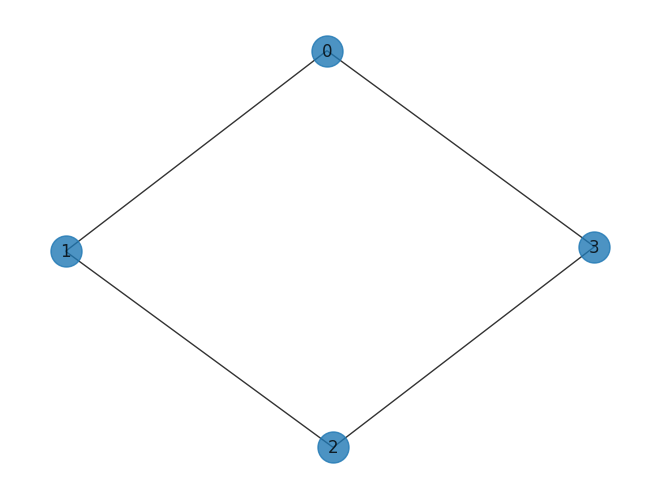

In [1]:
import networkx as nx
from qiskit import *
from qiskit.circuit import Parameter

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, with_labels=True, alpha=0.8, node_size=500)

### Gamma circuit; Problem hamiltonian.


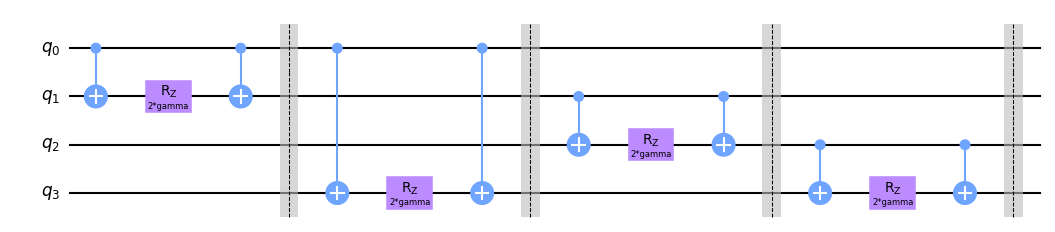

In [2]:
qc_gamma = QuantumCircuit(4)
gamma = Parameter('gamma')

for s,e in graph.edges():
    qc_gamma.cx(s,e)
    qc_gamma.rz(2*gamma, e)
    qc_gamma.cx(s,e)
    qc_gamma.barrier()

qc_gamma.draw(fold=1000, output="mpl", scale=0.75)


### Mixer hamiltonian

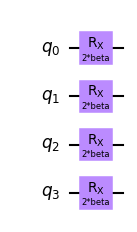

In [3]:
qc_mixer = QuantumCircuit(4)
beta = Parameter('beta')

for i in range(4):
    qc_mixer.rx(2*beta, i)

qc_mixer.draw(fold=1000, output="mpl", scale=0.75)



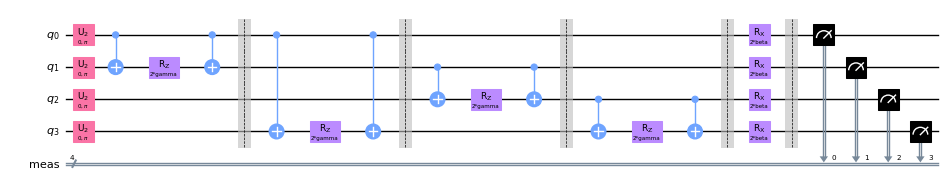

In [4]:
QC = QuantumCircuit(4)

for i in range(4):
    QC.h(i)

QC.append(qc_gamma, [0,1,2,3])
QC.append(qc_mixer, [0,1,2,3])
QC.measure_all()

QC = QC.decompose()

tqc = transpile(QC, backend=Aer.get_backend('aer_simulator'))

QC.draw(output="mpl", scale=0.5, fold=1000)


The objective of the function below is to take a specific solution and revert its solution to negative number to rhyme with the minimizer. 

In [5]:
def maxcut_obj(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [6]:
def quantum_circuit(graph):
    backend=Aer.get_backend('aer_simulator')

    def circuit_run(parameters):
        g, b = parameters
        a = assemble(tqc, backend=backend, shots=1,parameter_binds=[{beta: b, gamma: g}])
        counts = backend.run(a, shots=1000).result().get_counts() 
        return compute_expectation(counts, graph)
    return circuit_run

In [7]:
from scipy.optimize import minimize
expectation = quantum_circuit(graph)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')
res

/var/folders/n5/sr7wwb8n1wggd7jsk_k37l_w0000gn/T/ipykernel_24093/2149072633.py:7: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  counts = backend.run(a, shots=1000).result().get_counts()


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.918
       x: [ 1.958e+00  1.133e+00]
    nfev: 34
   maxcv: 0.0

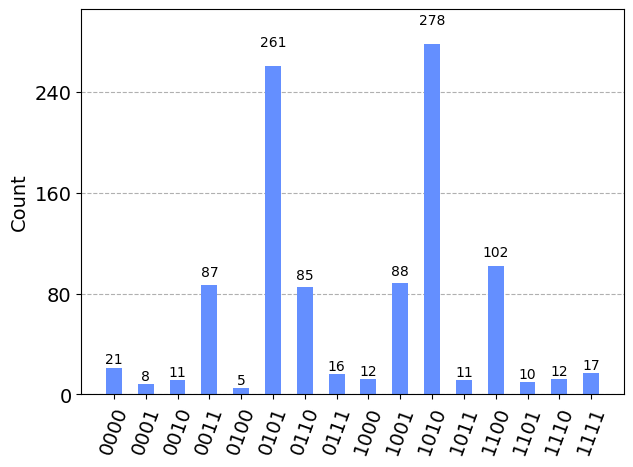

In [8]:
backend = Aer.get_backend('aer_simulator')
backend.shots = 512

from qiskit.visualization import plot_histogram
a = tqc.bind_parameters({beta: res.x[0], gamma: res.x[1]})
counts = backend.run(a, seed_simulator=10).result().get_counts()
plot_histogram(counts)

0101 and 1010 are the right solution. 